In [1]:
import os
import sys
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Importing code to simulate DENV and ZIKV transmission

Functions that simulate DENV and ZIKV transmission are found in a module named `pyflavi`, which is a wrapper around simulation code written in C++.

Before importing `pyflavi`, the latter needs to be compiled using `make` (see README). Compilation requires [`pybind11`](https://github.com/pybind/pybind11).

After compilation succeeds, `pyflavi` can be imported as any other Python module.

In [2]:
path_pyflavi = '../pyflavi/pyflavi/lib'
if path_pyflavi not in sys.path:
    sys.path.append( path_pyflavi )
    
import pyflavi

In [3]:
def get_checkpts( Tstart, Tstop, how ):

    '''
    Creates a list of time points between 'Tstart' and 'Tstop'
    with a given frequency
    '''
    
    assert( Tstart <= Tstop )

    if how == 'monthly':
        dts = [31,28,31,30,31,30,31,31,30,31,30,31]
    elif how == 'weekly':
        dts = [7] * 51 + [8]
    elif how == 'biweekly':
        dts = [14] * 25 + [15]
    elif how == 'yearly':
        dts = [365]
    else:
        raise ValueError( "Select a valid spacing" )

    ndts = len( dts )

    res = []
    i = 0
    t = Tstart - 1 + dts[0]
    while ( t < Tstop ):
        res.append( t )
        i = (i + 1) % ndts
        t += dts[i]

    return res

def simulate_ZIKV_usual( args ):

    '''
    Simulates ZIKV transmission in a population where DENV
    has been let spread for some time before ZIKV is introduced.
    
    Assumes that a recent ZIKV infections prevents DENV transmission.
    
    ZIKV is introduced by setting 10 individuals as infected with this virus.
    
    Returns incidence of DENV and ZIKV for 10 years
    after ZIKV introduction.
    '''
    
    #== Fixed parameters                                                                                                                                         
    N = 300000 # Population size
    Tsample = 100 * 365 # Sample incidence from this point
    TintroZ = Tsample # Time of Zika introduction
    Tmax = Tsample + 10 * 365 # Stopping time

    nstrains = 5 # Number of pathogens (4 DENV serotypes + ZIKV)
    epsiD = 1./15.9 # DENV incubation rate (1/days)
    epsiZ = 1./15.9 # ZIKV incubation rate (1/days)
    sigmaD = 1./4.5 # DENV recovery rate (1/days)
    sigmaZ = 1./4.5 # ZIKV recovery rate (1/days)
    intro_rate = 2. / 30 # DENV introduction rate
    mean_degree = 1. # Mean number of contacts made daily by individuals
    lD = 2. # Duration of cross-protection (years)
    seasD = 0.3 # Seasonal amplitude of DENV transmission
    seasZ = 0.  # Seasonal amplitude of ZIKV transmission
    peakD = 15. # Peak time (day) of DENV seasonality 
    peakZ = 0.  # Peak time (day) of ZIKV seasonality 
    age_shape = 3.3 # Weibull parameter of population age distribution (1)
    age_scale = 62  # Weibull parameter of population age distribution (2)

    # Cross reactivity parameters
    rhoDZ, rhoZD, rhoZD0 = 1., 1., 1. # Modified susceptibility to infection
    csiDZ, csiZD = 1., 0. # Modified susceptibility to transmission
    gamma1D, gamma2D = 1., 1. # Further arguments (unit value corresponds to no effect)
    gamma1Z, gamma2Z = 1., 1. # Further arguments (unit value corresponds to no effect)

    #== External arguments:
    # (1) R0 of ZIKV
    # (2) Duration of cross-protection following ZIKV infection
    # (3) R0 of DENV
    # (4) Seed for c++ random number generator
    # (5) Number of simulations
    # (6) Frequency of sampling
    R0Z, lZ, R0D, seed, Nsim, freqSampling = args
    
    betaZ = R0Z * sigmaZ # Transmission rate of ZIKV
    betaD = R0D * sigmaD # Transmission rate of DENV
    nZIKV0 = 10 # initial number of ZIKV cases

    # Define monthly sampling time points 
    checkpts = get_checkpts( Tsample, Tmax, freqSampling)

    # returns incidence
    inc = pyflavi.simulate_ZIKV( Nsim, seed, Tmax, Tsample, TintroZ, N, nstrains, [0,1,2,3], checkpts, False, betaD, betaZ, epsiD, epsiZ, sigmaD, sigmaZ,
                                 mean_degree, lD, lZ, intro_rate, seasD, seasZ, peakD, peakZ, age_shape, age_scale, rhoDZ, rhoZD, rhoZD0, csiDZ, csiZD, gamma1D, gamma1Z, gamma2D, gamma2Z, nZIKV0 )

    inc = np.array( inc )

    #np.save( path_save, inc )
    return inc

## Example simulation

Code below runs 10 simulations assuming that ZIKV is introduced by infecting 10 random individuals. ZIKV is then allowed to spread with $R_{0,Z} > 1$

DENV is let spread for 100 years before ZIKV is introduced so that DENV dynamics can be considered at equilibrium at that moment.

$R_{0,Z}$ is calibrated so that ZIKV gives rise to a given attack rate

In [4]:
#== Set parameters

Nsim = 10 # Number of independent simulations
propZ = 0.7 # ZIKV attack rate (0.7 means 70% of people are expected to become infected)
R0Z = - np.log( 1 - propZ ) / propZ # Retrieve the R0 of ZIKV corresponding to attack rate above
lZ = 1. # Duration of ZIKV-induced cross-protection (years)
R0D = 1.65 # R0 of DENV

#== Simulation (10 initial infected & onward transmission)
seed0 = 1 # Seed for random number generator
incUsual = simulate_ZIKV_usual( ( R0Z, lZ, R0D, seed0, Nsim, 'monthly' ) )



### Parsing the result

Both functions yield a numpy array with 4 axes:

1. Simulation axis (length: Nsim)
2. The number of time points (length: 120 = 10 years times 12 months per year
3. Type of incident case (length: 12, more below)
4. Age of incident case (length: 101, from 0 to 100 years)

About the third axis: the 'type' of incident case refers to:

- ZIKV infection (entries 0,1,2,3): The 4 subcategories correspond to 0,1,2,>2 past DENV infections, respectively
- DENV infection (entries 4,5,6,7,8,9,10,11): The 8 subcategories correspond to no previous ZIKV infection and 0,1,2,3 past DENV infections (entries 4,5,6,7) and a previous ZIKV infection and 0,1,2,3 past DENV infections (entries 8,9,10,11)

In [10]:
# show the shape of the resulting numpy array
incUsual.shape

(10, 120, 12, 101)

### Plotting DENV and ZIKV incidence

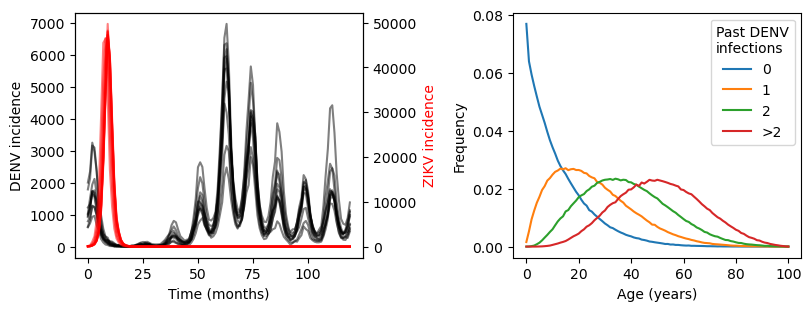

In [34]:
#== set up figure

fig, ax = plt.subplots( ncols = 2, figsize = ( 8, 3 ), constrained_layout = True  )

#== plot total DENV and ZIKV cases over time

# select DENV incident cases and sum over case age and case subtype
yD = incUsual[:,:,4:,:].sum( axis = (2,3) ) 
# select ZIKV incident cases and sum over case age and case subtype
yZ = incUsual[:,:,:4,:].sum( axis = (2,3) ) 

nsim = y.shape[0] # number of simulations

ax0b = ax[0].twinx() # define new axis to show ZIKV 
for sim in range( nsim ):
    ax[0].plot( yD[sim], c = 'black', alpha = 0.5 ) # plot DENV incidence
    ax0b.plot( yZ[sim], c = 'red', alpha = 0.5 ) # plot DENV incidence
    
ax[0].set_xlabel( 'Time (months)' )
ax[0].set_ylabel( 'DENV incidence' )

ax0b.set_ylabel( 'ZIKV incidence', c = 'red' )

#== plot the age distribution of ZIKV cases by number of previous ZIKV infections

# select ZIKV incident cases and sum over simulations and timesteps
yaZ = incUsual[:,:,:4].sum( axis = (0,1) ) 

labels = ['0','1','2','>2']
for i in range( 4 ):
    ax[1].plot( yaZ[i,:] / sum( yaZ[i,:] ), label = labels[i] ) # plot DENV incidence


ax[1].set_xlabel( 'Age (years)' )
ax[1].set_ylabel( 'Frequency' )

ax[1].legend( title = 'Past DENV\ninfections')

Checking that ZIKV attack rate is close to expected attack rate (*propZ*)

In [39]:
# get a list of attack rates per simulation
incUsual[:,:,:4,:].sum( axis = ( 1, 2, 3 ) ) / 300000

array([0.69992   , 0.70385   , 0.70324667, 0.70194   , 0.70290667,
       0.70322   , 0.70319   , 0.69886667, 0.70051667, 0.69898333])

## Simulating reported incidence

We transform simulated incidence into 'reported' incidence by weighting each incident case according to the number of prior DENV and ZIKV infections.

Weights encode the the modulating effect of prior infections on DENV severity. 

The weight corresponding to secondary DENV infections in ZIKV-naive individuals is set to 1 as a reference, as explained in the main manuscript.

In [22]:
def apply_weights_age( inc0, w, with_zikv = True ):
    
    '''
    Weights incidence ('inc0') according to weights 'w'
    Each weight applies to a different subtype of incident cases
    '''
    
    inc = inc0.copy()
    
    if with_zikv:

        inc[0,0,:]  = inc[0,0,:]  * w['wD0']
        inc[0,1,:]  = inc[0,1,:]  * w['wD1']
        inc[0,2,:]  = inc[0,2,:]  * w['wD2']
        inc[0,3:,:] = inc[0,3:,:] * w['wD2+']        

        inc[1,0,:]  = inc[1,0,:]  * w['wZD0']
        inc[1,1,:]  = inc[1,1,:]  * w['wZD1']
        inc[1,2,:]  = inc[1,2,:]  * w['wZD2']
        inc[1,3:,:] = inc[1,3:,:] * w['wZD2+'] 

        return inc
    else:

        inc[0,:]  = inc[0,:]  * w['wD0']
        inc[1,:]  = inc[1,:]  * w['wD1']
        inc[2,:]  = inc[2,:]  * w['wD2']
        inc[3:,:] = inc[3:,:] * w['wD2+']        

        return inc
    
def measure_mean_obs_age( inc, ws, iyear, midbins ):
    
    '''
    Measures mean age of reported/observed cases
    by first reconstructing reported incidence, which is
    obtained by weighting (ws) incidence (inc).
    Incidence is assumed to be measured yearly and 'iyear'
    selects incidence from a single year.
    '''
    
    tmp = inc.copy().astype( float )
    
    Nsim = tmp.shape[0] # number of simulations
    Ntsteps = tmp.shape[1] # number of time 
    
    res = []
    
    for sim in range( Nsim ): # loop over simulations
        
        #=== compute A(D|Z)
        incD = tmp[sim,iyear,4:,:] # get incidence by year
        incD = incD.reshape( 2, 4, 101 ) # reshape incidence
        
        incDobs = apply_weights_age( incD, ws, True )
        ageHistObs = incDobs.sum( axis = ( 0, 1 ) ) # sum over nZ and nD
        
        ageMeanObs = np.dot( midbins, ageHistObs ) / ageHistObs.sum() # get mean obs age
        res.append( ageMeanObs )
        
    return res

Here we define three different sets of weights corresponding to 3 distinct hypotheses about ZIKV-induced modulation of DENV severity:

- Null scenario: ZIKV does not affect DENV severity. Weights do not depend on presence or absence of a prior infection with ZIKV
- Scenario (i): ZIKV enhances disease in primary DENV infections as if these were secondary DENV infections. Effectively, ZIKV behaves as a fifth DENV serotype
- Scenario (ii): ZIKV enhances both primary and secondary DENV infections.

In [6]:
#= null hyp (ZIKV does not modify DENV severity)
ws_0 = { 'wD0': 0.33 , 'wD1': 1., 'wD2': 0.26, 'wD2+': 0., 
         'wZD0': 0.33, 'wZD1': 1., 'wZD2': 0.26, 'wZD2+': 0. }

#= hyp i (ZIKV as fifth serotype)
ws_i = { 'wD0': 0.33 , 'wD1': 1., 'wD2': 0.26, 'wD2+': 0., 
         'wZD0': 1., 'wZD1': 0.26, 'wZD2': 0., 'wZD2+': 0. }

#= hyp ii (ZIKV enhances D0 and D1)
ws_ii = { 'wD0': 0.33 , 'wD1': 1., 'wD2': 0.26, 'wD2+': 0., 
          'wZD0': 1., 'wZD1': 1., 'wZD2': 0., 'wZD2+': 0. }


Simulate DENV incidence

In [19]:
#== Set parameters

Nsim = 10 # Number of independent simulations
propZ = 0.7 # ZIKV attack rate (0.7 means 70% of people are expected to become infected)
R0Z = - np.log( 1 - propZ ) / propZ # Retrieve the R0 of ZIKV corresponding to attack rate above
lZ = 1. # Duration of ZIKV-induced cross-protection (years)
R0D = 1.65 # R0 of DENV

#== Simulation (10 initial infected & onward transmission)
seed0 = 1 # Seed for random number generator
incUsual = simulate_ZIKV_usual( ( R0Z, lZ, R0D, seed0, Nsim, 'yearly' ) )

Now calculate mean observed age in the fourth year after ZIKV is introduced, and average over simulations

In [28]:
mean_obs_0  = np.mean( measure_mean_obs_age( incUsual, ws_0, 3, np.arange( 101 ) ) )
mean_obs_i  = np.mean( measure_mean_obs_age( incUsual, ws_i, 3, np.arange( 101 ) ) )
mean_obs_ii = np.mean( measure_mean_obs_age( incUsual, ws_ii, 3, np.arange( 101 ) ) )

print( 'Null hypothesis:',  mean_obs_0, 'y')
print( 'Hypothesis (i):',   mean_obs_i, 'y')
print( 'Hypothesis (ii):',  mean_obs_ii, 'y')

Null hypothesis: 24.513030386320388 y
Hypothesis (i): 18.86434622961503 y
Hypothesis (ii): 21.1817492801291 y


This should be compared with the mean age of reported cases in **absence of ZIKV**
To this end, we run simulations where ZIKV transmissibility is set to 0 so that no transmission occurs.

In [32]:
seed1 = 2 # Seed for random number generator
incReference = simulate_ZIKV_usual( ( 0., lZ, R0D, seed1, Nsim, 'yearly' ) ) 

Mean observed age in absence of ZIKV is then (any of the 3 sets of weights works):

In [35]:
mean_obs_ref  = np.mean( measure_mean_obs_age( incReference, ws_0, 3, np.arange( 101 ) ) )
print( mean_obs_ref )

24.14108938334129


For any set of weights, the age shift is calculated as:

$$\Delta = \dfrac{A(D|Z) - A(D)}{A(D)}$$

Where $A(D), A(D|Z)$ represent the mean age of reported cases in absence and presence of ZIKV, respectively.

In [36]:
Δ_0  = ( mean_obs_0 - mean_obs_ref ) / mean_obs_ref
Δ_i  = ( mean_obs_i - mean_obs_ref ) / mean_obs_ref
Δ_ii = ( mean_obs_ii - mean_obs_ref ) / mean_obs_ref

print( 'Null hypothesis:',  Δ_0, 'y')
print( 'Hypothesis (i):',   Δ_i, 'y')
print( 'Hypothesis (ii):',  Δ_ii, 'y')

Null hypothesis: 0.015406968470766672 y
Hypothesis (i): -0.2185793304492509 y
Hypothesis (ii): -0.12258519307974144 y


# Further simulations with seroprevalence-informed initialisations

This section shows how to simulate DENV with a particular initial age-profile of seroprevalence (further details can be found in the manuscript).

In addition, ZIKV is initialised by setting a (large) proportion of the population as infected while preventing onward transmission ($R_{0,Z}=0$)

Here we use a serological age profile relative to Salvador, Bahia (2015), obtained from [Rodriguez-Barraquer et Al., *Science*, 2019](https://www.science.org/doi/10.1126/science.aav6618?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) 

Text(0, 0.5, 'Proportion seropositive')

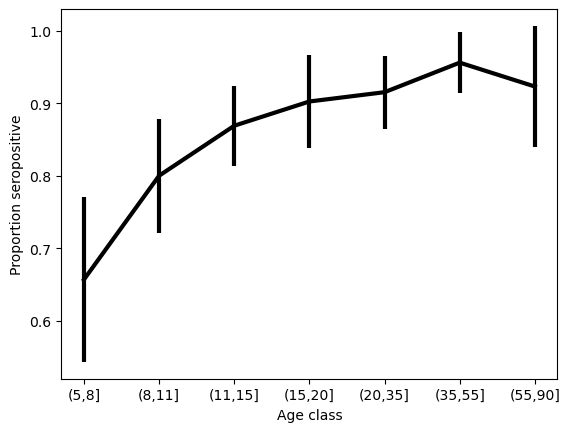

In [43]:
#== plot seroprevalence profile

sero_salvador = {
    'age' : [ '(0,5]', '(5,8]', '(8,11]', '(11,15]', '(15,20]', '(20,35]', '(35,55]', '(55,90]' ],
    'val' : [ np.nan, 0.65671642, 0.80000000, 0.86896552, 0.90243902, 0.91525424, 0.95604396, 0.92307692 ],
    'n'   : [ 0, 67, 100, 145, 82, 118, 91, 39 ]
}

x = np.array( sero_salvador['age'] )
y = np.array( sero_salvador['val'] )
n = np.array( sero_salvador['n'] )

# plot seroprevalence alongside the estimated error
plt.errorbar( x, y, yerr = 1.96 * np.sqrt( y * ( 1 - y ) / n ), color = 'black', 
               label = 'Data (Isabel,Salvador)', lw = 3 )

plt.xlabel('Age class')
plt.ylabel('Proportion seropositive')

In [46]:
def simulate_ZIKV_serology_informed( args ):

    '''
    Simulates ZIKV transmission in a population where background DENV immunity
    and initial prevalence are determined by an external serological profile.
    
    Assumes that a recent ZIKV infections prevents DENV transmission.
        
    ZIKV is introduced by infecting a (large) fraction propZ of hosts,
    while onward transmission is fully prevented.
    
    Returns incidence of DENV and ZIKV for 5 years
    after ZIKV introduction.
    '''
    
    #== Fixed parameters                                                                                                                                         
    N = 300000 # Population size
    Tsample = 0 # Sample incidence from this point
    TintroZ = 40 # Time of Zika introduction
    Tmax = Tsample + 5 * 365 # Stopping time

    nstrains = 5 # Number of pathogens (4 DENV serotypes + ZIKV)
    epsiD = 1./15.9 # DENV incubation rate (1/days)
    epsiZ = 1./15.9 # ZIKV incubation rate (1/days)
    sigmaD = 1./4.5 # DENV recovery rate (1/days)
    sigmaZ = 1./4.5 # ZIKV recovery rate (1/days)
    intro_rate = 2. / 30 # DENV introduction rate
    mean_degree = 1. # Mean number of contacts made daily by individuals
    lD = 2. # Duration of cross-protection (years)
    seasD = 0.3 # Seasonal amplitude of DENV transmission
    seasZ = 0.  # Seasonal amplitude of ZIKV transmission
    peakD = 15. # Peak time (day) of DENV seasonality 
    peakZ = 0.  # Peak time (day) of ZIKV seasonality 
    age_shape = 3.3 # Weibull parameter of population age distribution (1)
    age_scale = 62  # Weibull parameter of population age distribution (2)

    # Cross reactivity parameters
    rhoDZ, rhoZD, rhoZD0 = 1., 1., 1. # Modified susceptibility to infection
    csiDZ, csiZD = 1., 0. # Modified susceptibility to transmission
    gamma1D, gamma2D = 1., 1. # Further arguments (unit value corresponds to no effect)
    gamma1Z, gamma2Z = 1., 1. # Further arguments (unit value corresponds to no effect)
    
    # serology parameters
    sero_lam1 = np.exp(-3.23) / 365.
    sero_lam2 = np.exp(-6.55) / 365.
    sero_a0 = 16. * 365

    #== External arguments:
    # (1) proportion of ZIKV
    # (2) Duration of cross-protection following ZIKV infection
    # (3) R0 of DENV
    # (4) Seed for c++ random number generator
    # (5) Number of simulations
    # (6) Frequency of sampling
    propZ, lZ, R0D, seed, Nsim, freqSampling = args
    
    betaZ = 0. # No ZIKV transmission
    betaD = R0D * sigmaD # Transmission rate of DENV
    nZIKV0 = int( propZ * N ) # initial number of ZIKV cases

    # Define monthly sampling time points 
    checkpts = get_checkpts( Tsample, Tmax, freqSampling)

    # returns incidence
    inc = pyflavi.simulate_ZIKV_sero( Nsim, seed, Tmax, Tsample, TintroZ, N, nstrains, 
                                     [0,1,2,3], checkpts, False, betaD, betaZ, epsiD, 
                                     epsiZ, sigmaD, sigmaZ, mean_degree, lD, lZ, 
                                     intro_rate, seasD, seasZ, peakD, peakZ, age_shape, 
                                     age_scale, rhoDZ, rhoZD, rhoZD0, csiDZ, csiZD, 
                                     gamma1D, gamma1Z, gamma2D, gamma2Z, 
                                     sero_lam1, sero_lam2, sero_a0, nZIKV0 )

    inc = np.array( inc )

    #np.save( path_save, inc )
    return inc

In [48]:
#== Set parameters

Nsim = 10 # Number of independent simulations
propZ = 0.7 # ZIKV attack rate (0.7 means 70% of people are expected to become infected)
R0Z = - np.log( 1 - propZ ) / propZ # Retrieve the R0 of ZIKV corresponding to attack rate above
lZ = 1. # Duration of ZIKV-induced cross-protection (years)
R0D = 1.65 # R0 of DENV

#== Simulation (10 initial infected & onward transmission)
seed0 = 1 # Seed for random number generator
incSero = simulate_ZIKV_serology_informed( ( propZ, lZ, R0D, seed0, Nsim, 'yearly' ) ) 

Incidence can then be analysed by using the same machinery presented above.
For example, the mean age of reported cases assuming that ZIKV behaves as a fifth DENV serotype is:

In [51]:
np.mean( measure_mean_obs_age( incSero, ws_i, 3, np.arange( 101 ) ) )

22.18848443068223